In [48]:
!pip install bcubed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
import os
import gc
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score

import tensorflow_hub as hub
import bcubed

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls drive/MyDrive/test_for_ml.zip

drive/MyDrive/test_for_ml.zip


In [ ]:
!mkdir drive/MyDrive/test_ml

In [ ]:
!unzip drive/MyDrive/test_for_ml.zip -d drive/MyDrive/test_ml

Archive:  drive/MyDrive/test_for_ml.zip
  inflating: drive/MyDrive/test_ml/application_control.csv  
  inflating: drive/MyDrive/test_ml/atm_security.csv  
  inflating: drive/MyDrive/test_ml/CASB.csv  
  inflating: drive/MyDrive/test_ml/EDR.csv  
  inflating: drive/MyDrive/test_ml/honeypot.csv  
  inflating: drive/MyDrive/test_ml/industrial_iot_security.csv  
  inflating: drive/MyDrive/test_ml/malware_detect.csv  
  inflating: drive/MyDrive/test_ml/MDR.csv  
  inflating: drive/MyDrive/test_ml/NDR.csv  
  inflating: drive/MyDrive/test_ml/NGFW.csv  
  inflating: drive/MyDrive/test_ml/parental_control.csv  
  inflating: drive/MyDrive/test_ml/ransomware_detect.csv  
  inflating: drive/MyDrive/test_ml/sandbox.csv  
  inflating: drive/MyDrive/test_ml/SASE.csv  
  inflating: drive/MyDrive/test_ml/SIEM.csv  
  inflating: drive/MyDrive/test_ml/SOAR.csv  
  inflating: drive/MyDrive/test_ml/spyware_detect.csv  
  inflating: drive/MyDrive/test_ml/system_tweak.csv  
  inflating: drive/MyDrive/test_m

Задание (взято из реального кейса):

1. Имеется 20 csv файлов, каждый описывает некоторую технологию (название файла – название технологии). Технология описывается новостями за последние 3 года.
2. Надо создать классификатор, который будет предсказывать по входному тексту, к какой технологии относится новость.
3. Классификатор должен быть мультиклассовым – т.е. один текст может иметь метки разных технологий.
4. Необходимые метрики соискатель должен выбрать сам, обосновать их выбор и предоставить значения метрик для обученного классификатора.
5. Выбор фреймворка и модели остается за соискателем.
6. Будет плюсом если соискатель проверит разные модели, приведет значения метрик и обоснует выбор одной из моделей для потенциального запуска в продакшн.

# Примеры текстов для каждой технологии

In [ ]:
!ls drive/MyDrive/test_ml

anti-counterfeit.csv	     malware_detect.csv     SASE.csv
application_control.csv      MDR.csv		    SIEM.csv
atm_security.csv	     NDR.csv		    SOAR.csv
CASB.csv		     NGFW.csv		    spyware_detect.csv
EDR.csv			     parental_control.csv   system_tweak.csv
honeypot.csv		     ransomware_detect.csv  unwanted_programs.csv
industrial_iot_security.csv  sandbox.csv


In [ ]:
counterfeit = pd.read_csv('drive/MyDrive/test_ml/anti-counterfeit.csv')
application_control = pd.read_csv('drive/MyDrive/test_ml/application_control.csv')

In [ ]:
counterfeit.head(2)

,id,published_date,title,language,topic,link,country,summary
0,8df4cbef454b703efc1fa2182fa19464,2022-11-15 18:35:33,RFID Anti-Counterfeiting Tag market: Market Pl...,en,business,https://www.openpr.com/news/2808352/rfid-anti-...,DE,RFID Anti-Counterfeiting Tag market: Market Pl...
1,55e4319b28151bf88de62331a9d78935,2022-11-11 03:18:53,Global Anti-Counterfeit Packaging Market SWOT ...,en,business,https://www.openpr.com/news/2802747/global-ant...,DE,Global Anti-Counterfeit Packaging Market SWOT ...


In [ ]:
application_control.head(2)

,id,published_date,title,language,topic,link,country,summary
0,182e2db6b3c40ec8fec833f848cb2bd9,2022-11-29 09:56:00,Application Control Market Size worth US$ 2.24...,en,news,https://www.openpr.com/news/2825937/applicatio...,DE,Application Control Market Size worth US$ 2.24...
1,2f951409667012d264ddfd69a6ea6f16,2022-11-23 08:11:51,Application Control Gateway Market Analysis an...,en,news,https://heraldkeeper.com/market/application-co...,unknown,Application Control Gateway Market Business ov...


In [ ]:
counterfeit['topic'].value_counts(normalize=True)

news             0.864477
business         0.034977
finance          0.031704
science          0.014571
world            0.013552
economics        0.009910
politics         0.008829
tech             0.007934
entertainment    0.005063
gaming           0.002655
food             0.001852
sport            0.001729
beauty           0.001389
travel           0.000432
music            0.000432
energy           0.000309
opinion          0.000154
topic            0.000031
Name: topic, dtype: float64

In [ ]:
counterfeit.shape[0], counterfeit['id'].nunique()

(32396, 32042)

In [ ]:
application_control.shape[0], application_control['id'].nunique()

(5238, 5218)

In [ ]:
counterfeit = counterfeit.drop_duplicates()

In [ ]:
cnt_id = counterfeit.groupby('id').size()
counterfeit[counterfeit['id'] == cnt_id[cnt_id > 1].index[0]]['published_date']

17698    2021-09-26 07:15:00
31852    2020-02-15 05:45:00
Name: published_date, dtype: object

По одному id могут отличаться ссылки (link), сам текст (summary) и дата публикации (published_date).

In [ ]:
cnt_id = counterfeit.groupby('id').size()
counterfeit[counterfeit['id'] == cnt_id[cnt_id > 1].index[2]]

,id,published_date,title,language,topic,link,country,summary
24504,0caa264c258b8c57dc3b86abf15af55b,2021-04-20 10:38:19,Boosting Wide‐Range Tunable Long‐Afterglow in ...,en,news,https://onlinelibrary.wiley.com/doi/10.1002/ad...,US,"Volume 33, Issue 16 2007571 Molecular afterglo..."
25849,0caa264c258b8c57dc3b86abf15af55b,2021-03-09 16:49:14,Boosting Wide‐Range Tunable Long‐Afterglow in ...,en,news,https://onlinelibrary.wiley.com/doi/10.1002/ad...,US,Early View 2007571 First published: 09 March 2...


In [ ]:
np.all(counterfeit[counterfeit['id'] == cnt_id[cnt_id > 1].index[0]]['summary'].iloc[0] == counterfeit[counterfeit['id'] == cnt_id[cnt_id > 1].index[0]]['summary'].iloc[1])

True

In [ ]:
cnt_id = application_control.groupby('id').size()
application_control[application_control['id'] == cnt_id[cnt_id > 1].index[0]]

,id,published_date,title,language,topic,link,country,summary
3656,05680e7fd5cfb0d40e569ef84a0ad157,2021-07-08 12:14:45,Application Control Market to Witness Growth A...,en,business,https://www.openpr.com/news/2324305/applicatio...,DE,NaN
4916,05680e7fd5cfb0d40e569ef84a0ad157,2021-01-21 12:09:17,Application Control Market to Witness Growth A...,en,news,https://www.openpr.com/news/2228994/applicatio...,DE,"In terms of revenue, the global application co..."
5039,05680e7fd5cfb0d40e569ef84a0ad157,2020-09-15 12:30:49,Application Control Market to Witness Growth A...,en,news,https://www.openpr.com/news/2134541/applicatio...,DE,"In terms of revenue, the global application co..."


In [ ]:
counterfeit.shape[0], counterfeit['id'].nunique()

(32396, 32042)

Выбираются наблюдения с первой датой публикации в случае совпадения всех остальных полей ('id', 'title', 'language', 'topic', 'link', 'country', 'summary').

In [ ]:
application_control = application_control.drop('rn', axis=1)

In [ ]:
application_control['rn'] = application_control.sort_values(['id', 'title', 'language', 'topic', 'link', 'country', 'summary', 'published_date'])\
                                .groupby(['id', 'title', 'language', 'topic', 'link', 'country', 'summary'])\
                                .cumcount() + 1

In [ ]:
cnt_id = application_control.groupby('id').size()
application_control[application_control['id'] == cnt_id[cnt_id > 1].index[0]]

,id,published_date,title,language,topic,link,country,summary,rn
3656,05680e7fd5cfb0d40e569ef84a0ad157,2021-07-08 12:14:45,Application Control Market to Witness Growth A...,en,business,https://www.openpr.com/news/2324305/applicatio...,DE,NaN,NaN
4916,05680e7fd5cfb0d40e569ef84a0ad157,2021-01-21 12:09:17,Application Control Market to Witness Growth A...,en,news,https://www.openpr.com/news/2228994/applicatio...,DE,"In terms of revenue, the global application co...",1.0
5039,05680e7fd5cfb0d40e569ef84a0ad157,2020-09-15 12:30:49,Application Control Market to Witness Growth A...,en,news,https://www.openpr.com/news/2134541/applicatio...,DE,"In terms of revenue, the global application co...",1.0


In [ ]:
application_control = application_control[application_control['rn'] == 1].drop('rn', axis=1)

In [ ]:
application_control.shape[0], application_control['id'].nunique()

(5226, 5212)

Во всех текстах язык английский.

In [ ]:
folder_name = 'drive/MyDrive/test_ml'

uniq_languages = []
for f in glob.glob(folder_name + "/*.csv"):
    tech_df = pd.read_csv(f, sep=',')
    tech_df['label'] = f[22:-4]
    uniq_languages.append(tech_df['language'].unique())

In [ ]:
uniq_languages

[array(['en'], dtype=object),
 array(['en'], dtype=object),
 array(['en'], dtype=object),
 array(['en'], dtype=object),
 array(['en'], dtype=object),
 array(['en'], dtype=object),
 array(['en'], dtype=object),
 array(['en'], dtype=object),
 array(['en'], dtype=object),
 array(['en'], dtype=object),
 array(['en'], dtype=object),
 array(['en'], dtype=object),
 array(['en'], dtype=object),
 array(['en'], dtype=object),
 array(['en'], dtype=object),
 array(['en'], dtype=object),
 array(['en'], dtype=object),
 array(['en'], dtype=object),
 array(['en'], dtype=object),
 array(['en'], dtype=object)]

# Все технологии

### Подготовка датафрейма для моделирования

In [3]:
folder_name = 'drive/MyDrive/test_ml'
# dataframe = pd.concat([pd.read_csv(f, sep=',') for f in glob.glob(folder_name + "/*.csv")], ignore_index=True)

dataframes = []
for f in glob.glob(folder_name + "/*.csv"):
    tech_df = pd.read_csv(f, sep=',')
    tech_df['label'] = f[22:-4]

    tech_df['rn'] = tech_df.sort_values(['id', 'title', 'language', 'topic', 'link', 'country', 'summary', 'published_date'])\
                                .groupby(['id', 'title', 'language', 'topic', 'link', 'country', 'summary'])\
                                .cumcount() + 1
    tech_df = tech_df[tech_df['rn'] == 1].drop('rn', axis=1)
    dataframes.append(tech_df)
    del tech_df
    gc.collect()

df = pd.concat(dataframes, ignore_index=True)

In [5]:
df.shape

(397422, 9)

In [ ]:
df.head()

,id,published_date,title,language,topic,link,country,summary,label
0,c6d59b5ad56b1bc31037cb44461ff961,2022-11-09 00:00:00,Detecting the Presence of Malware and Identify...,en,science,https://www.mdpi.com/2079-9292/11/22/3665,CH,Malware is malicious software (harmful program...,malware_detect
1,6b720fb4a0fe32c4474271a11873c5a4,2022-11-18 14:00:15,Malwarebytes vs. Norton Antivirus: Which Is Be...,en,news,https://www.makeuseof.com/malwarebytes-vs-nort...,CA,If you're looking for antimalware software to ...,malware_detect
2,1d8df0b77f5cd1d3c803ee7e16746739,2022-11-29 00:00:00,Malware Detection in Internet of Things (IoT) ...,en,science,https://www.mdpi.com/1424-8220/22/23/9305,CH,"Department of Computer Science, Shaheed Zulfik...",malware_detect
3,eb58b9b7536a15d600e7382aa5d4587f,2022-11-03 00:00:00,Malware Analysis and Detection Using Machine L...,en,science,https://www.mdpi.com/2073-8994/14/11/2304,CH,Open AccessArticle by and * School of Computer...,malware_detect
4,b9d62fd2fa1d6b3dfe5d5d87a8182b41,2022-11-26 11:49:00,All You Need to Know About Emotet in 2022,en,tech,https://thehackernews.com/2022/11/all-you-need...,IN,"For 6 months, the infamous Emotet botnet has s...",malware_detect


In [ ]:
df['label'].value_counts(normalize=True)

unwanted_programs          0.207424
malware_detect             0.159428
ransomware_detect          0.146864
industrial_iot_security    0.141162
anti-counterfeit           0.080708
parental_control           0.037217
spyware_detect             0.035265
EDR                        0.029213
MDR                        0.025859
SASE                       0.023154
sandbox                    0.020414
SIEM                       0.017201
application_control        0.013150
CASB                       0.012933
atm_security               0.011273
honeypot                   0.009677
system_tweak               0.009481
SOAR                       0.007896
NDR                        0.006026
NGFW                       0.005654
Name: label, dtype: float64

In [ ]:
cnt_id = df.groupby('id').size()
df[df['id'] == cnt_id[cnt_id > 1].index[0]]

,id,published_date,title,language,topic,link,country,summary,label
35450,000102f214b825978f4f6840c9c45700,2021-10-13 00:00:00,BlackBerry Shines Spotlight on Evolving Cobalt...,en,news,https://www.uppermichiganssource.com/prnewswir...,US,"Nation-state backed APT groups, cyber mercenar...",malware_detect
100669,000102f214b825978f4f6840c9c45700,2021-10-13 00:00:00,BlackBerry Shines Spotlight on Evolving Cobalt...,en,news,https://www.uppermichiganssource.com/prnewswir...,US,"Nation-state backed APT groups, cyber mercenar...",ransomware_detect


Таргет, подходящий для многоклассовой классификации (multilabel), где у одного объекта может быть несколько меток.

In [6]:
df1 = pd.concat([df, pd.get_dummies(df['label'])], axis=1)

df2 = df1.groupby(['id', 'published_date', 'title', 'language', 'topic', 'country', 'summary'])\
      .agg({label: 'max' for label in df['label'].unique()})\
      .reset_index()

df2 = df2.sample(frac=1., random_state=1).reset_index(drop=True)

In [ ]:
# Есть статьи с одинаковым id и текстом, но отличающиеся темой
# Таких наблюдений мало (менее 100), поэтому
df2.shape[0], df2[['id', 'summary']].drop_duplicates().shape[0]

(329669, 329592)

In [ ]:
df2.head()

,id,published_date,title,language,topic,country,summary,malware_detect,ransomware_detect,SIEM,...,honeypot,sandbox,application_control,anti-counterfeit,industrial_iot_security,spyware_detect,parental_control,system_tweak,unwanted_programs,atm_security
0,000030cdb5b89ebe444e7a0a7853b4be,2020-07-30 18:46:00,"Ventiv Design Launches its Sustainable, Anti- ...",en,news,US,"Their material selection, including glass, pla...",0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0000ceab291d9f447f07bbacc288d9a8,2022-03-25 04:03:06,Context Aware Computing Market,en,news,DE,Context Aware Computing Market size is estimat...,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0000f3586858df5aafeccc4513b928d1,2023-01-09 19:30:44,WhatsApp's Pegasus spyware lawsuit can go ahea...,en,news,AU,Israeli firm NSO Group s spyware has been link...,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,000102f214b825978f4f6840c9c45700,2021-10-13 00:00:00,BlackBerry Shines Spotlight on Evolving Cobalt...,en,news,US,"Nation-state backed APT groups, cyber mercenar...",1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,000117e5527263e15b7d4dbadd1fd141,2023-01-03 19:25:43,How to tell if your cell phone has been secret...,en,news,unknown,We've all been instructed to be alert for pote...,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [ ]:
df1[df1['id'] == '000102f214b825978f4f6840c9c45700']

,id,published_date,title,language,topic,link,country,summary,label,CASB,...,atm_security,honeypot,industrial_iot_security,malware_detect,parental_control,ransomware_detect,sandbox,spyware_detect,system_tweak,unwanted_programs
35450,000102f214b825978f4f6840c9c45700,2021-10-13 00:00:00,BlackBerry Shines Spotlight on Evolving Cobalt...,en,news,https://www.uppermichiganssource.com/prnewswir...,US,"Nation-state backed APT groups, cyber mercenar...",malware_detect,0,...,0,0,0,1,0,0,0,0,0,0
100669,000102f214b825978f4f6840c9c45700,2021-10-13 00:00:00,BlackBerry Shines Spotlight on Evolving Cobalt...,en,news,https://www.uppermichiganssource.com/prnewswir...,US,"Nation-state backed APT groups, cyber mercenar...",ransomware_detect,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
df2[df2['id'] == '000102f214b825978f4f6840c9c45700']

,id,published_date,title,language,topic,country,summary,malware_detect,ransomware_detect,SIEM,...,honeypot,sandbox,application_control,anti-counterfeit,industrial_iot_security,spyware_detect,parental_control,system_tweak,unwanted_programs,atm_security
3,000102f214b825978f4f6840c9c45700,2021-10-13 00:00:00,BlackBerry Shines Spotlight on Evolving Cobalt...,en,news,US,"Nation-state backed APT groups, cyber mercenar...",1,1,0,...,0,0,0,0,0,0,0,0,0,0


# EDA

Распределение количества новостей по месяцам публикации. Данные с января 2020 по март 2023. В основном, в выборке представлены наблюдения за 2021-2022 гг.

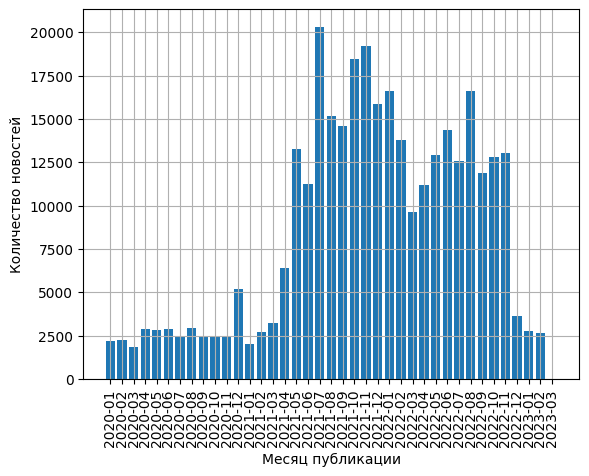

In [ ]:
dynamics = df2.groupby(df2['published_date'].apply(lambda x: x[:7])).size()

plt.figure()
plt.bar(dynamics.index, dynamics.values)
plt.xticks(rotation=90)
plt.ylabel('Количество новостей')
plt.xlabel('Месяц публикации')
plt.grid()
plt.show()

Какие категории статей были опубликованы по месяцам. В 2023 г. не представлены наиболее популярные классы на всей остальной выборке (malware_detect, ransomware_detect).

In [ ]:
target_distribution = df2.groupby(df2['published_date'].apply(lambda x: x[:7])).agg({label: 'sum' for label in df2.columns[-20:]})
target_distribution

,malware_detect,ransomware_detect,SIEM,SASE,NGFW,NDR,SOAR,EDR,CASB,MDR,honeypot,sandbox,application_control,anti-counterfeit,industrial_iot_security,spyware_detect,parental_control,system_tweak,unwanted_programs,atm_security
published_date,,,,,,,,,,,,,,,,,,,,
2020-01,800,300,38,17,20,8,16,70,13,38,74,86,29,356,577,0,0,0,0,0
2020-02,800,400,75,29,21,13,40,66,44,38,39,113,21,320,593,0,0,0,0,0
2020-03,700,200,51,41,29,8,12,46,40,38,42,90,21,336,442,0,0,0,0,0
2020-04,796,200,60,40,15,4,21,59,31,36,48,82,23,347,468,116,187,167,601,56
2020-05,600,200,72,36,25,6,21,46,35,41,36,86,15,540,408,83,133,31,665,70
2020-06,500,200,63,47,15,17,29,73,48,57,33,65,24,846,461,113,141,17,555,23
2020-07,498,100,70,57,16,14,22,34,37,43,39,60,11,369,415,88,228,32,640,49
2020-08,698,300,65,74,32,14,38,151,50,60,37,107,33,405,491,89,191,55,516,67
2020-09,699,399,60,62,25,12,33,84,34,81,39,64,22,435,458,81,241,46,1,66


In [ ]:
df2['language'].value_counts()

en    329669
Name: language, dtype: int64

In [ ]:
df2['topic'].value_counts()

news             276426
tech              14972
business          12920
finance            8591
world              5107
science            2950
economics          2821
politics           2282
entertainment      1509
gaming             1026
sport               437
energy              187
beauty              121
food                114
travel              101
music                40
topic                40
opinion              25
Name: topic, dtype: int64

In [ ]:
df2['country'].value_counts()

US         194832
unknown     26210
GB          24507
IN          23837
CA           8647
            ...  
SY              1
GU              1
SH              1
GM              1
MG              1
Name: country, Length: 172, dtype: int64

Ниже представлен график распределения количества слов в статьях -- распределение с тяжелым хвостом (есть выбросы (где длина статей около 200 тыс. слов)). На графике отражена частота встречаемости для статей с количеством слов и символом < 10000.

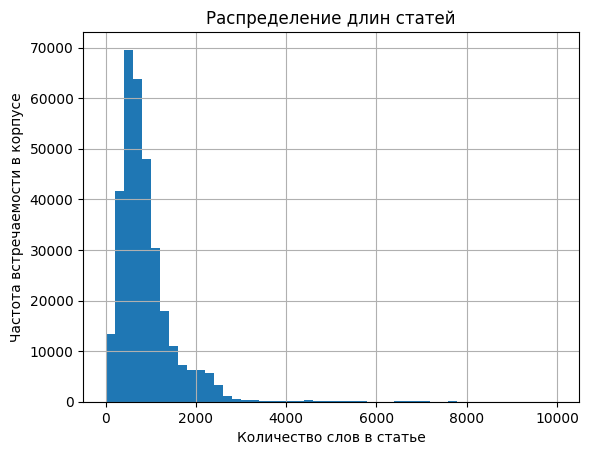

In [ ]:
len_summary = df2['summary'].apply(lambda x: len(x.split()))

plt.figure()
len_summary[len_summary < 10000].hist(bins=50)
plt.title('Распределение длин статей')
plt.ylabel('Частота встречаемости в корпусе')
plt.xlabel('Количество слов в статье')
plt.show()

Распределение классов не сбалансировано: из 20 классов чаще всего встречаются 5.

In [ ]:
targets = df2.columns[-20:]
target_distribution = pd.DataFrame(100 * df2[df2.columns[-20:]].sum() / df2.shape[0], columns=['share'])\
                      .reset_index()
target_distribution = target_distribution.sort_values(by='share', ascending=False)

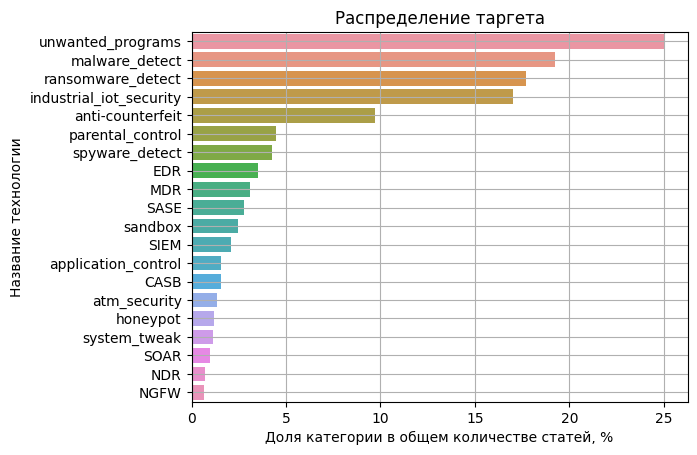

In [ ]:
plt.figure()
sns.barplot(data=target_distribution, x='share', y='index')
plt.title('Распределение таргета')
plt.ylabel('Название технологии')
plt.xlabel('Доля категории в общем количестве статей, %')
plt.grid()
plt.show()

# Train-test split

In [9]:
df2['published_date'] = pd.to_datetime(df2['published_date'])

oot = df2[df2['published_date'] >= '2022-11-01 00:00:00'].copy()
train_val = df2[df2['published_date'] < '2022-11-01 00:00:00'].copy()

In [12]:
# targets = df2.columns[-20:]

train, val = train_test_split(train_val, test_size=0.3, random_state=777)

In [ ]:
train.head(2)

,id,published_date,title,language,topic,country,summary,malware_detect,ransomware_detect,SIEM,...,honeypot,sandbox,application_control,anti-counterfeit,industrial_iot_security,spyware_detect,parental_control,system_tweak,unwanted_programs,atm_security
312800,f2f93dfc8a05a8c9428f1aec18ac65de,2021-11-22 19:30:15,Lebanese Republic responds to the trade in ill...,en,news,IN,"LONDON, Nov. 22, 2021 (GLOBE NEWSWIRE) — OpSec...",0,0,0,...,0,0,0,1,0,0,0,0,0,0
140862,de5d4ac3a6924f85c770b0596d4c7437,2021-06-17 23:59:19,Cruise giant Carnival says customers affected ...,en,news,US,(AP) - Carnival Corp. said Thursday that a dat...,0,1,0,...,0,0,0,0,0,0,0,0,0,0


# Генерация признаков

Язык исключается из признаков, т.к. он не позволяет разделять наблюдения (язык у всех статей английский).
Кроме того, отнесение статьи к определенной технологии не должно зависеть от даты публикации,
поэтому в данном случае признаки на основе даты публикации (например, время публикации, день недели и т.п.) не будем включать в модель, т.к. это может привести к переобучению.

Для бейзлайна посмотрим на эмбеддинги заголовка статьи, получаемые из обученной модели с tensorflow_hub. Энкодер предложений позволяет подавать на вход необработанные тексты. Заголовок статьи модет служить весьма сильным предиктором, т.к. в нем обычно отражается суть всей статьи или зачастую перефразируется сама статья. Кроме того, заголовок меньше по объему статьи, что позволит посмотреть на качество алгоритмов за меньшее время.

In [ ]:
# В качестве эмбеддингов можно обучить word2vec для слов и далее для предложений получить средний вектор по словам
# Здесь необходима предварительная обработка тектов (токенизация, удаление стоп-слов и т.д.)

# from gensim.models import Word2Vec
# model = Word2Vec(train_summary, vector_size=100, window=5, min_count=5, workers=4)
# model.save("word2vec.model")
# w2v_model = Word2Vec.load("word2vec.model")

# class MeanEmbeddingVectorizer(object):
#     def __init__(self, word2vec):
#         self.word2vec = word2vec
#         self.dim = len(list(word2vec.values())[0])

#     def fit(self, X, y):
#         return self

#     def transform(self, X):
#         return np.array([
#             np.mean([self.word2vec[w] for w in words if w in self.word2vec]
#                     or [np.zeros(self.dim)], axis=0)
#             for words in X
#         ])

In [10]:
# Предобученная модель для обработки предложений
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [13]:
title_embeddings = np.zeros((train.shape[0], 512))

for i, t in enumerate(list(train['title'].values)):
    emb = embed([t])
    title_embeddings[i, :] = emb.numpy()

In [17]:
val_title_embeddings = np.zeros((val.shape[0], 512))

for i, t in enumerate(list(val['title'].values)):
    emb = embed([t])
    val_title_embeddings[i, :] = emb.numpy()

In [18]:
title_embeddings.shape, val_title_embeddings.shape

((215322, 512), (92282, 512))

In [35]:
oot_title_embeddings = np.zeros((oot.shape[0], 512))

for i, t in enumerate(list(oot['title'].values)):
    emb = embed([t])
    oot_title_embeddings[i, :] = emb.numpy()

## Моделирование

In [21]:
# Линейный классификатор
clf = RidgeClassifier(random_state=7).fit(title_embeddings, train.iloc[:, -20:])

In [22]:
train_pred = clf.predict(title_embeddings)
val_pred = clf.predict(val_title_embeddings)
oot_pred = clf.predict(oot_title_embeddings)

In [40]:
print('Train')
print('Precision ', precision_score(train.iloc[:, -20:], train_pred, average='micro'))
print('Recall ', recall_score(train.iloc[:, -20:], train_pred, average='micro'))
print('F1 ', f1_score(train.iloc[:, -20:], train_pred, average='micro'))
print('='*30)
print('Validation')
print('Precision ', precision_score(val.iloc[:, -20:], val_pred, average='micro'))
print('Recall ', recall_score(val.iloc[:, -20:], val_pred, average='micro'))
print('F1 ', f1_score(val.iloc[:, -20:], val_pred, average='micro'))
print('='*30)
print('OOT')
print('Precision ', precision_score(oot.iloc[:, -20:], oot_pred, average='micro'))
print('Recall ', recall_score(oot.iloc[:, -20:], oot_pred, average='micro'))
print('F1 ', f1_score(oot.iloc[:, -20:], oot_pred, average='micro'))

Train
Precision  0.8167655587776043
Recall  0.3519999692371584
F1  0.4919745572099998
Validation
Precision  0.8142937184834713
Recall  0.35216197296860696
F1  0.49168311248942764
OOT
Precision  0.7432371708456906
Recall  0.3187880656849896
F1  0.44619493377215463


In [85]:
print('Train')
print('Precision ', precision_score(train.iloc[:, -20:], train_pred, average='weighted'))
print('Recall ', recall_score(train.iloc[:, -20:], train_pred, average='weighted'))
print('F1 ', f1_score(train.iloc[:, -20:], train_pred, average='weighted'))
print('='*30)
print('Validation')
print('Precision ', precision_score(val.iloc[:, -20:], val_pred, average='weighted'))
print('Recall ', recall_score(val.iloc[:, -20:], val_pred, average='weighted'))
print('F1 ', f1_score(val.iloc[:, -20:], val_pred, average='weighted'))
print('='*30)
print('OOT')
print('Precision ', precision_score(oot.iloc[:, -20:], oot_pred, average='weighted'))
print('Recall ', recall_score(oot.iloc[:, -20:], oot_pred, average='weighted'))
print('F1 ', f1_score(oot.iloc[:, -20:], oot_pred, average='weighted'))

Train


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision  0.6819544213620756
Recall  0.3519999692371584
F1  0.44434325640386335
Validation


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision  0.671191002887307
Recall  0.35216197296860696
F1  0.4439906837978916
OOT
Precision  0.6079460009659996
Recall  0.3187880656849896
F1  0.4000857108529819


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
train_true = train.iloc[:, -20:].values
val_true = val.iloc[:, -20:].values
oot_true = oot.iloc[:, -20:].values

Помимо стандартных метрик качества алгоритмов обучения с учителем может быть полезно смотреть на метрики bcubed, используемые в задачах обучения без учителя.
bcubed отражает качество алгоритма кластеризации лучше, чем традиционная f-метрика, используемая для задач классификации. Bcubed оценивает качество внутри каждого класса (с точки зрения точности: однородность внутри каждого класса) и качество по отношению к истинным меткам (с точки зрения полноты: однородность между классами), таким образом, он оценивает общее качество, в то время как обычный f-score оценивает каждую конкретную метку и в определенном смысле не учитывает во внимание "кластеризацию".

In [71]:
def compute_bcubed(ground_truth, predictions):
    assert ground_truth.shape == predictions.shape

    gold = {i:set() for i in range(ground_truth.shape[0])}
    pred = {i:set() for i in range(predictions.shape[0])}

    for i in range(ground_truth.shape[0]):
        for j in range(ground_truth.shape[1]):
            if ground_truth[i, j] == 1:
                gold[i].add(j)
            if predictions[i, j] == 1:
                pred[i].add(j)
    precision = bcubed.precision(pred, gold)
    recall = bcubed.recall(pred, gold)
    f_score = bcubed.fscore(precision, recall)
    return precision, recall, f_score

In [78]:
precision, recall, f_score = compute_bcubed(train_true, train_pred)
print('Train')
print('Precision-BCubed: {:.3f}, Recall-BCubed: {:.3f}, F-BCubed: {:.3f},'.format(precision, recall, f_score))

Train
Precision-BCubed: 0.832, Recall-BCubed: 0.560, F-BCubed: 0.635,


In [81]:
val_precision, val_recall, val_f_score = compute_bcubed(val_true, val_pred)
print('Validation')
print('Precision-BCubed: {:.3f}, Recall-BCubed: {:.3f}, F-BCubed: {:.3f},'.format(val_precision, val_recall, val_f_score))

Validation
Precision-BCubed: 0.829, Recall-BCubed: 0.573, F-BCubed: 0.677,


С точки зрения bcubed-метрик, линейный алгоритм показывает стабильно высокую точность, как на OOT, так и на OOS.

In [43]:
# случайный лес
# алгоритм с максимальной глубиной деревьев > 3 также переобучается
rf = RandomForestClassifier(max_depth=3, random_state=0)
rf.fit(title_embeddings, train.iloc[:, -20:])

RandomForestClassifier(max_depth=3, random_state=0)

In [44]:
rf_train_pred = rf.predict(title_embeddings)
rf_val_pred = rf.predict(val_title_embeddings)
rf_oot_pred = rf.predict(oot_title_embeddings)

In [47]:
print('Train')
print('Precision ', precision_score(train.iloc[:, -20:], rf_train_pred, average='micro'))
print('Recall ', recall_score(train.iloc[:, -20:], rf_train_pred, average='micro'))
print('F1 ', f1_score(train.iloc[:, -20:], rf_train_pred, average='micro'))
print('='*30)
print('Validation')
print('Precision ', precision_score(val.iloc[:, -20:], rf_val_pred, average='micro'))
print('Recall ', recall_score(val.iloc[:, -20:], rf_val_pred, average='micro'))
print('F1 ', f1_score(val.iloc[:, -20:], rf_val_pred, average='micro'))
print('='*30)
print('OOT')
print('Precision ', precision_score(oot.iloc[:, -20:], rf_oot_pred, average='micro'))
print('Recall ', recall_score(oot.iloc[:, -20:], rf_oot_pred, average='micro'))
print('F1 ', f1_score(oot.iloc[:, -20:], rf_oot_pred, average='micro'))

Train
Precision  0.9993634627625716
Recall  0.006037207656871265
F1  0.012001911132345913
Validation
Precision  1.0
Recall  0.00603090840557859
F1  0.011989509179467967
OOT
Precision  1.0
Recall  0.0004240228201372292
F1  0.0008476862019805031


In [90]:
print('Train')
print('Precision ', precision_score(train.iloc[:, -20:], rf_train_pred, average='weighted'))
print('Recall ', recall_score(train.iloc[:, -20:], rf_train_pred, average='weighted'))
print('F1 ', f1_score(train.iloc[:, -20:], rf_train_pred, average='weighted'))
print('='*30)
print('Validation')
print('Precision ', precision_score(val.iloc[:, -20:], rf_val_pred, average='weighted'))
print('Recall ', recall_score(val.iloc[:, -20:], rf_val_pred, average='weighted'))
print('F1 ', f1_score(val.iloc[:, -20:], rf_val_pred, average='weighted'))
print('='*30)
print('OOT')
print('Precision ', precision_score(oot.iloc[:, -20:], rf_oot_pred, average='weighted'))
print('Recall ', recall_score(oot.iloc[:, -20:], rf_oot_pred, average='weighted'))
print('F1 ', f1_score(oot.iloc[:, -20:], rf_oot_pred, average='weighted'))

Train


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision  0.19760230281115243
Recall  0.006037207656871265
F1  0.011716450631855236
Validation


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision  0.19817636817259884
Recall  0.00603090840557859
F1  0.011705591932142607
OOT
Precision  0.3443450774805335
Recall  0.0004240228201372292
F1  0.0008470026503322605


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


В качестве метрики качества для итогового принятия решения о выборе лучшей модели можно использовать precision, т.к. в данном случае важнее правильно
классифицировать новость, чем полностью охватить весь класс (и каждый класс). Т.е. ошибка первого рода имеет более высокую цену в данной задаче, чем ошибка второго рода. В целом, это можно учесть через взвешенный F-score, в котором больший вес будет стоять перед precision (F-score - среднее гармоническое точности и полноты).

В данном случае используется микро-усреденение по разным классам, т.к. оно позволяет в меньшей степени учитывать редкие классы. В свою очередь макро-усреднение учитывает каждый класс с равным весом, что может быть полезно, если требуется учесть все классы одинаково. В данной задаче не обязательно предсказывать с высокой точностью каждый класс, скорее важно общее предсказание по всем. Также полезно мониторить точность, взвешенную на долю классов.

Сравнивая линейный алгоритм и случайный лес на эмбеддингах заголовка, более стабильной моделью является линейная регрессия. Несмотря на то, что у случайного леса выше точность, чем у линейной модели, f1-score выше у линейной модели (при микро-усреднении). Кроме того, точность случайного леса около 1, что может сигнализировать о переобучении (фичи стабильны во времени и распределение фичей не меняется на обучении и валидации, в результате качество на валидации также остается на высоком уровне). При взвешивании классов с учетом их распределения качество линейного классификатора выше по всем метрикам, чем у случайного леса.
Таким образом, итоговая модель - линейный классификатор, построенный на эмбеддингах заголовков новостей.

Для улучшения качества прогнозирования требуется рассмотрение дополнительных признаков:
* эмбеддинги самих текстов;
* тему новости (topic);
* страна.

Категориальные признаки (тема новости и страна) можно, например, добавить через OneHotEncoder.